# Mask Generation

In [1]:
from climpyrical.mask import rotate_shapefile, gen_raster_mask_from_vector
from climpyrical.gridding import *
from climpyrical.data import read_data, interpolate_dataset, gen_dataset

from pkg_resources import resource_filename

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd

font = {'weight' : 'bold',
        'size'   : 28}
matplotlib.rc('font', **font)
plt.rcParams['figure.figsize'] = (18, 18)

# Generate Mask from High-Res Model

The original CanRCM4 model comes with 50km x 50km grid cells. These need to be increased to the final NRC resolution of 5 km x 5 km grid cells.

The only available land masks for CanRCM4 models are at the native resolution, and miss out on finer detailed coastlines. 

Fix this by using more detailed shapefiles that can clip a raster. 

Start by loading in more detailed shapefiles. NaturalEarthData.com provide extremely useful shapefiles that are well maintained. 

In [2]:
# from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_1_states_provinces.zip
land_shape_path = resource_filename('climpyrical', 'data/vectors/ne_50m_admin_1_states_provinces.shp')

s = gpd.read_file(land_shape_path)

# select Canada only
c = s[s.iso_a2 == "CA"].geometry

# transform to rotated pole CRS
# CanRCM4 models come in an elusive (and seldom documented) projection
# string called `rotated pole`. This projection is defined by default
# in climpyrical.mask.rotate_shapefile. Custom projection proj4 dictionaries
# can also be used.

rotate_shapefile?

Signature:
rotate_shapefile(
    p: Union[geopandas.geoseries.GeoSeries, geopandas.geodataframe.GeoDataFrame],
    crs: dict = {'proj': 'ob_tran', 'o_proj': 'longlat', 'lon_0': -97, 'o_lat_p': 42.5, 'a': 6378137, 'to_meter': 0.0174532925199, 'no_defs': True},
) -> geopandas.geoseries.GeoSeries
Docstring:
Rotates a shapefile to a new crs defined by a proj4 dictionary.
Uses geopandas crs functions.
Args:
    p (geopandas.GeoSeries object): polygons of Canada
    crs (dict): proj4 dictionary
Returns:
    target (geopandas.GeoSeries object): geographic polygons
        in new projection
File:      ~/12182020/climpyrical/climpyrical/mask.py
Type:      function


CRS epsg:4326


/home/nannau/12182020/myvenv/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


<AxesSubplot:>

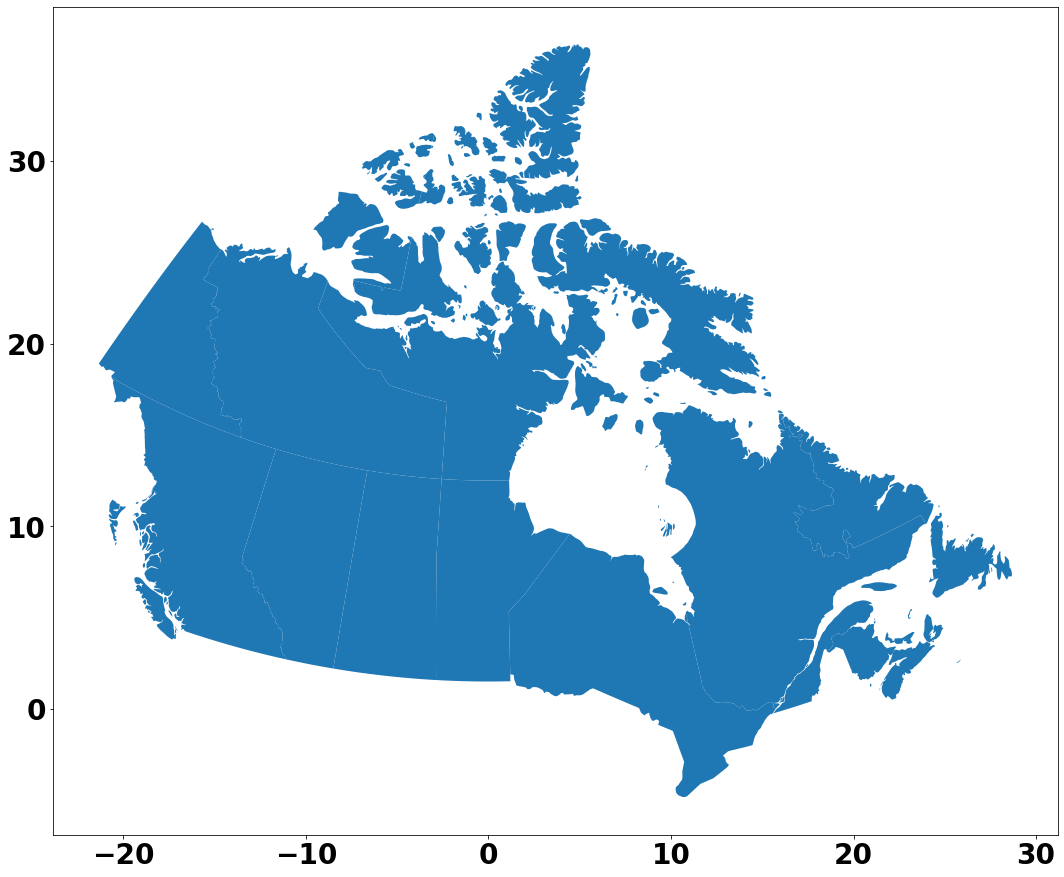

In [3]:
rp_c = rotate_shapefile(c)
rp_c.plot()

Load in an additional shapefile from NaturalEarthData containing lakes. We can use this to cut out the largest lakes from our shapefile by using GeoPandas overlay function.

To use the overlay function on geopandas, users must have rtree installed. 

The easiest way to do this is with
```bash
sudo apt-get install -y libspatialindex-dev
pip install rtree
```

In [4]:
# from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_lakes.zip
# note that 50m does not include great lakes for unknown reasons
lake_shape_path = resource_filename('climpyrical', 'data/vectors/ne_10m_lakes.shp')
lakes = gpd.read_file(lake_shape_path)

# select only larger lakes
g_lakes = lakes[lakes.area >= 0.2]#'Great Lakes']
g_lakes = rotate_shapefile(g_lakes.geometry)

g_lakes, rp_c
# remove lakes from mask
canada = gpd.overlay(gpd.GeoDataFrame(rp_c), gpd.GeoDataFrame(g_lakes), how='difference')

CRS epsg:4326


/home/nannau/12182020/myvenv/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


Text(0.5, 1.0, 'Rotated Shapefile with Great Lakes Removed')

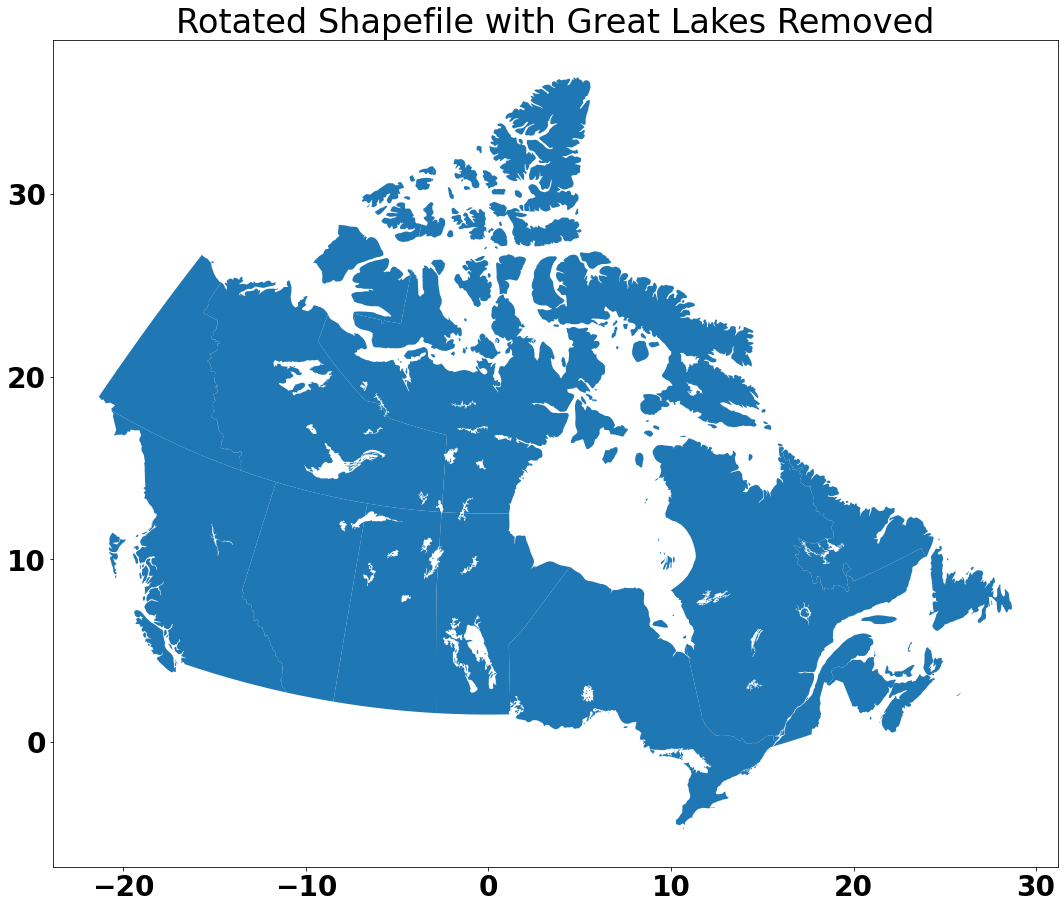

In [5]:
canada.plot()
plt.title('Rotated Shapefile with Great Lakes Removed')

Load the standard Surface to Land Fraction mask, `sftlf`. We will use this mask as a reference to generate our raster mask from our modified shapefile.

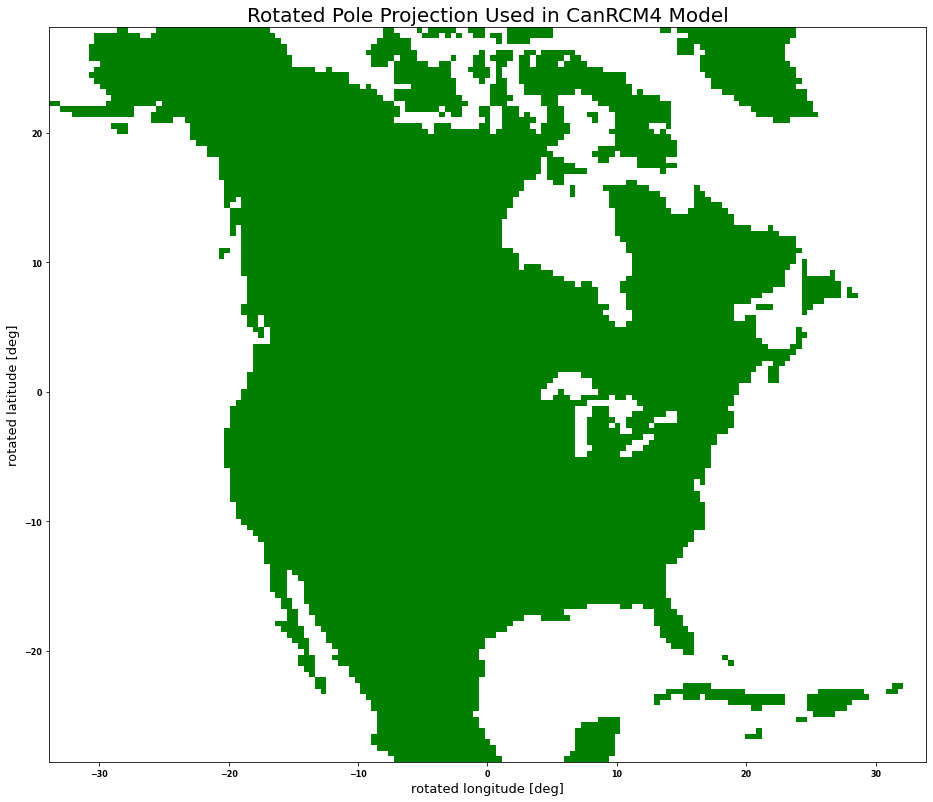

In [6]:
# PCIC internal. Available upon request, or in repo
PATH_MEAN = resource_filename('climpyrical', 'data/masks/land_mask_CanRCM4_sftlf.nc')

mask = read_data(PATH_MEAN)
key = 'sftlf'
    
# assign physical coordinates on axis
extent = [mask.rlon.min(), mask.rlon.max(), mask.rlat.min(), mask.rlat.max()]
    
# view mask
font = {'weight' : 'bold',
        'size'   : 8}

matplotlib.rc('font', **font)
plt.rcParams['figure.figsize'] = (13, 13)
plt.figure(figsize=(13, 13))
plt.imshow(mask[key], origin='lower', extent=extent, cmap='ocean_r', label='CanRCM4 Surface to Land Fraction  > 0.0 Mask')
plt.xlabel('rotated longitude [deg]', fontsize=13)
plt.ylabel('rotated latitude [deg]', fontsize=13)
plt.plot()
plt.title('Rotated Pole Projection Used in CanRCM4 Model', fontsize=20)
plt.tight_layout()

Create an downscaled version of the mask by copying nearby values.

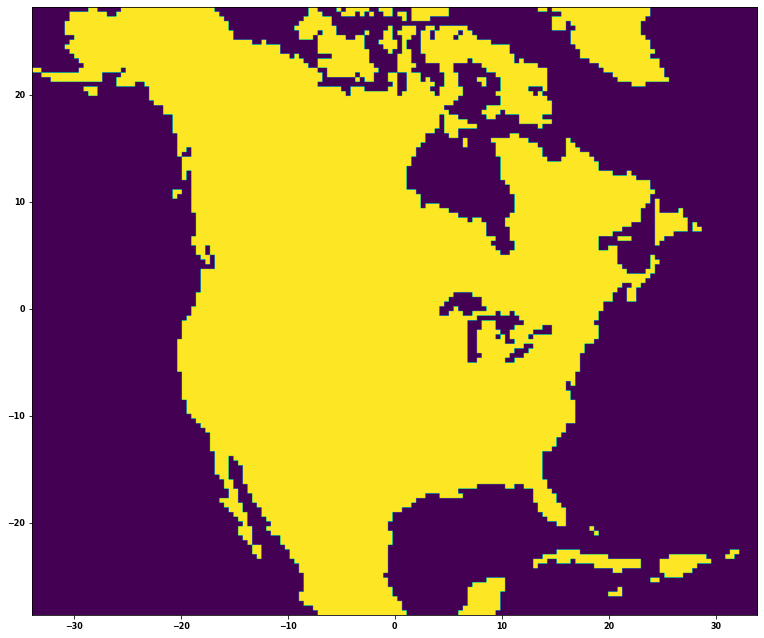

In [7]:
N = 10
mask10 = regrid_ensemble(mask, key, N, copy=True)

plt.imshow(mask10[key], origin='lower', extent=extent)

In [8]:
print("New mask shape:")
mask10

New mask shape:


<xarray.Dataset>
Dimensions:  (rlat: 1300, rlon: 1550)
Coordinates:
  * rlat     (rlat) float64 -29.0 -28.95 -28.91 -28.86 ... 28.47 28.51 28.56
  * rlon     (rlon) float64 -34.28 -34.23 -34.19 -34.14 ... 34.19 34.23 34.28
    lat      (rlat, rlon) float64 11.85 11.87 11.88 11.9 ... 59.16 59.13 59.1
    lon      (rlat, rlon) float64 232.8 232.8 232.9 232.9 ... 337.3 337.4 337.4
Data variables:
    sftlf    (rlat, rlon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

# Extend northern region
Extend CanRCM4 models to include regions in then north (i.e. Nunuvut). Add rows of pixels to north. This can be done before or after regridding to high-res - so long as it sufficiently covers Nunuvut. 

In [9]:
mask10_ext = extend_north(mask10, key, 210, fill_val=False)
new_extent = [mask10_ext.rlon.min(), mask10_ext.rlon.max(), mask10_ext.rlat.min(), mask10_ext.rlat.max()]

In [10]:
mask10_ext

<xarray.Dataset>
Dimensions:  (rlat: 1510, rlon: 1550)
Coordinates:
  * rlat     (rlat) float64 -29.0 -28.95 -28.91 -28.86 ... 37.77 37.82 37.86
  * rlon     (rlon) float64 -34.28 -34.23 -34.19 -34.14 ... 34.19 34.23 34.28
    lat      (rlat, rlon) float64 11.85 11.87 11.88 11.9 ... 63.66 63.62 63.59
    lon      (rlat, rlon) float64 232.8 232.8 232.9 232.9 ... 354.5 354.5 354.5
Data variables:
    sftlf    (rlat, rlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

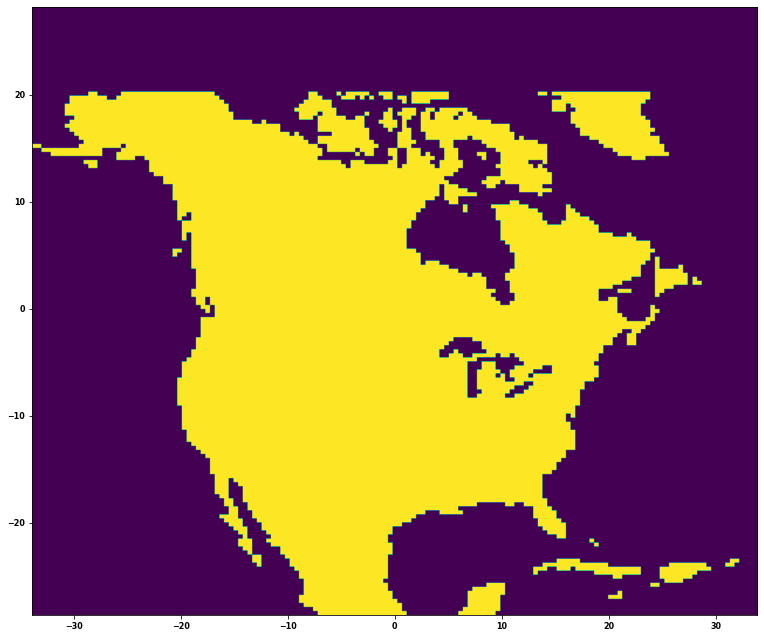

In [11]:
plt.imshow(mask10_ext[key], origin='lower', extent=extent)

# Clip raster from vector

Each grid cell in the CanRCM4 model has an extent that is considered in this mask. In order to account for this, a grid cell is considered included in the mask if it intersects with the geometry of the polygon we provide. 

`gen_raster_mask_from_vector` generates this mask using the coordinates from the coordinates provided

In [12]:
final_mask = gen_raster_mask_from_vector(mask10_ext.rlon.values, mask10_ext.rlat.values,  canada)

100%|██████████| 1051830/1051830 [07:01<00:00, 2493.12it/s]


Generate the dataset. From here, you can export to netCDF, or whatever file format `xarray` supports.

In [13]:
new_mask = gen_dataset(
    'mask', 
    final_mask, 
    mask10_ext.rlat.values, 
    mask10_ext.rlon.values, 
    mask10_ext.lat.values, 
    mask10_ext.lon.values
)

Compare new mask with the original shapefile. They should line up fairly well.

<AxesSubplot:>

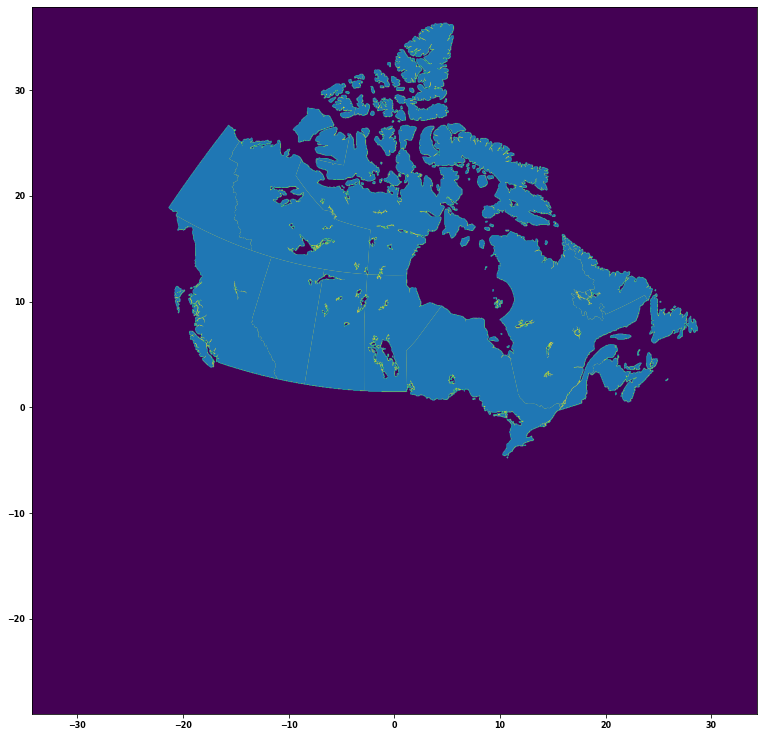

In [14]:
fig, ax = plt.subplots()
ax.imshow(final_mask, origin='lower', extent=new_extent)
canada.plot(ax=ax)